# 1 - Data Preprocessing

## 1.0. Data Collection 

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = ' '
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.csv')  

id = ' '
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.csv')  

import pandas as pd
training_data = pd.read_csv("/content/training_data.csv")
testing_data = pd.read_csv("/content/testing_data.csv")

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data.iloc[-1,0], training_data.iloc[-1,1]))
print("------------------------------------")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim.downloader as api
from sklearn.metrics import accuracy_score
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk.stem.porter import *
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from gensim.models import FastText
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)
import matplotlib.pyplot as plt
import pandas as pd
import re
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

------------------------------------
Size of training dataset: 7808
Size of testing dataset: 867
------------------------------------
------------------------------------
Sample Data
LABEL: F / SENTENCE: 'Half of it is going straight to charity, another quarter going straight to scientific research, an eighth to the parkour community, a sixteenth to towards spreading information about health and...|||Find a path or suffer more.|||http://personalitycafe.com/enneagram-personality-theory-forum/85323-enneagram-type-mbti-type-compared-statistics.html yep.|||I kind of anchor on Fi and Ne makes having Ni really fun. INFP for me as they tire me out less and our views tend to align more.|||The two ESTPs I have gotten the chance to know seem to experience much more than other people who have been on the planet for the same amount of time and are quite the renaissance (wo)men.  Is this...|||I don't really have a best friend ISTP(passion-amateur group co-founder), INTJ(intellectual and various sma

In [ ]:
# (1)type - label of the post (2)posts - the corresponding post content
training_data.head()

,type,posts
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,T,'I'm finding the lack of me in these posts ver...
2,T,'Good one _____ https://www.youtube.com/wat...
3,T,"'Dear INTP, I enjoyed our conversation the o..."
4,T,'You're fired.|||That's another silly misconce...


In [ ]:
# Extract the labels and posts and store into List

# Get the list of training data (posts)
training_posts=training_data['posts'].tolist()
# Get the list of corresponding labels for the training data (posts)
training_labels=training_data['type'].tolist()
# Get the list of testing data (posts)
testing_posts=testing_data['posts'].tolist()
# Get the list of corresponding labels for the testing data (posts)
testing_labels=testing_data['type'].tolist()

In [ ]:
training_posts[1:5]

## 1.1. URL Removal


In [ ]:

pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
# Process training data
training_posts_remove_url=[]
for sentense in training_posts:
  sentense = re.sub(pattern, '', sentense)
  training_posts_remove_url.append(sentense)

# Process test data
test_posts_remove_url=[]
for sentense in testing_posts:
  sentense = re.sub(pattern, '', sentense)
  test_posts_remove_url.append(sentense)

## 1.2. Preprocess data (e.g. Stop words, Stemming)

In [ ]:

# Process training data
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  # Remove url
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower 
  lower_tokens = [t.lower() for t in tokenized_sentence]
  #remove stop words
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  # Stemming
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  # Lemmatisation
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

# Process test data
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  # Remove url
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # Lower
  lower_tokens = [t.lower() for t in tokenized_sentence]
  # Remove stop words
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  #stemming
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  # Lemmatisation
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2 - Input Representation


## 2.1. Word Embedding Construction


In [ ]:

# In practice, we only use the vocabulary from training data
# training data + test data
model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

# create look up table for dataset
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1


# Word embedding ussing FastText(SG), window sizes = 100
# use both training and test data
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size #200
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)  


# Label encoding
# training set
from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)

unique_labels = np.unique(training_labels)

# test set
from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

## 2.2. Pretrained Word Embedding

In [ ]:

# Pretrained word embedding: glove-twitter-200
# download the model and return as object ready for use
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

## 2.3. Input Concatenation

In [ ]:
# Concatenation
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*ft_sg_model.vector_size),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Set total length to 700
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# 3 - Model Implementation

### 3.1. Build Sequence Model (Bi-directional model)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False)

vocab_size = len(word_list)
total_epoch = 125
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 3.2. Train Sequence Model (Bi-directional model)

In [ ]:

for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    # Accuracy of training data
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())
    print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))

print('Finished Training')

# F1 score on test data
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)
# classification_report builds a text report showing the main classification metrics
print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
perprocess= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')
print('F1 score of data processing without URL + without stop words + lower case + stemming + lemmatizes,\nword embedding: FastText(SG) + glove-twitter-200,\n model:Bi-LSTM : {:.3f}%'.format(perprocess*100)) #48.717%

Epoch: 1, loss: 0.72491, train_acc: 0.54
Epoch: 2, loss: 0.76567, train_acc: 0.47
Epoch: 3, loss: 0.70835, train_acc: 0.59
Epoch: 4, loss: 0.72797, train_acc: 0.52
Epoch: 5, loss: 0.71229, train_acc: 0.55
Epoch: 6, loss: 0.71668, train_acc: 0.52
Epoch: 7, loss: 0.72214, train_acc: 0.50
Epoch: 8, loss: 0.69553, train_acc: 0.55
Epoch: 9, loss: 0.70340, train_acc: 0.52
Epoch: 10, loss: 0.69483, train_acc: 0.52
Epoch: 11, loss: 0.69725, train_acc: 0.50
Epoch: 12, loss: 0.70452, train_acc: 0.51
Epoch: 13, loss: 0.67795, train_acc: 0.57
Epoch: 14, loss: 0.69159, train_acc: 0.54
Epoch: 15, loss: 0.69235, train_acc: 0.54
Epoch: 16, loss: 0.70475, train_acc: 0.54
Epoch: 17, loss: 0.68420, train_acc: 0.53
Epoch: 18, loss: 0.68632, train_acc: 0.58
Epoch: 19, loss: 0.68535, train_acc: 0.52
Epoch: 20, loss: 0.70252, train_acc: 0.55
Epoch: 21, loss: 0.69845, train_acc: 0.50
Epoch: 22, loss: 0.68421, train_acc: 0.54
Epoch: 23, loss: 0.68995, train_acc: 0.52
Epoch: 24, loss: 0.68326, train_acc: 0.52
E

# 4 - Evaluation


## 4.1. Word Embedding Evaluation


The code compares the performance of word embedding with dimension of 100, 200, 250 and window sizes of 3, 5, 10.
The results show that when the dimension is 100, which is the smallest of the three selected dimensions, the accuracy rate is the highest.
Similarly, 3 is the smallest among three selected window sizes and has the highest accuracy.
When the window size is small, this word embedding represents a closer relationship with similar words. If the window size is larger, the word embedding will become very general, because the information contained in each embedding has a lot of overlap. Therefore, it is reasonable that when window size equals to 3, the model present in a more accurate way. Since small window size can help word embedding contain more precise and specific meaning.  

Dimension controls the word embedding length, the longer size of embedding, the more information it contains. Theoretically, the larger the dimension, the better it performs, but according to the experiment, when the dimension is 100, the best accuracy is obtained in the test. It may be because we don't have enough data to train it, since the high dimension requires more data for calculation. 

Dimensions: 100, window sizes: 5
Cloning into 'GloVe'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 606 (delta 5), reused 7 (delta 2), pack-reused 592
Receiving objects: 100% (606/606), 224.91 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (343/343), done.
Vocab size:  33573
capital-common-countries.txt:
ACCURACY TOP1: 1.11% (1/90)
capital-world.txt:
ACCURACY TOP1: 0.00% (0/88)
currency.txt:
ACCURACY TOP1: 0.00% (0/18)
city-in-state.txt:
ACCURACY TOP1: 1.81% (6/331)
family.txt:
ACCURACY TOP1: 31.67% (76/240)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 51.84% (451/870)
gram2-opposite.txt:
ACCURACY TOP1: 59.00% (354/600)
gram3-comparative.txt:
ACCURACY TOP1: 44.67% (595/1332)
gram4-superlative.txt:
ACCURACY TOP1: 60.86% (566/930)
gram5-present-participle.txt:
ACCURACY TOP1: 69.57% (647/930)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 43.16% (366/848)
gram7-past-tense.txt:
ACCUR

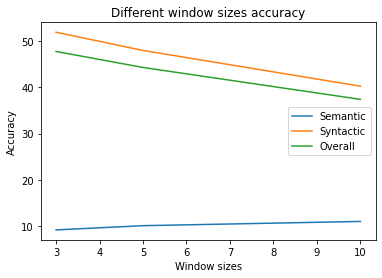

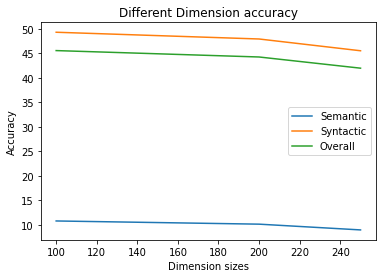

In [ ]:

sem_acc_win={}
syn_acc_win ={}
tot_acc_win ={}
sem_acc_dim={}
syn_acc_dim={}
tot_acc_dim={}

# Word embedding 1
# Dimensions: 100, window sizes: 5
print('Dimensions: 100, window sizes: 5')
from gensim.models import FastText
ft_sg_model_1 = FastText(model_train_docs, size=100, window=5, min_count=5, workers=2, sg=1)
ft_sg_model_1.wv.save_word2vec_format('ted_ft_w2v_1.txt', binary=False)
!git clone https://github.com/stanfordnlp/GloVe.git
vectors_file="/content/ted_ft_w2v_1.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100
    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)

            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()
   
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))


sem_acc_dim[100] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_dim[100]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_dim[100] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)
print('='*40)

print('Dimensions: 200, window sizes: 3')
ft_sg_model_3 = FastText(model_train_docs, size=200, window=3, min_count=5, workers=2, sg=1)
ft_sg_model_3.wv.save_word2vec_format('ted_ft_w2v_3.txt', binary=False)
!git clone https://github.com/stanfordnlp/GloVe.git
vectors_file="/content/ted_ft_w2v_3.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T


def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))
print('='*40)
sem_acc_win[3] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_win[3]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_win[3] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)


# Word embedding 2
# Dimensions: 200, window sizes: 5
print('Dimensions: 200, window sizes: 5')
ft_sg_model_3 = FastText(model_train_docs, size=200, window=5, min_count=5, workers=2, sg=1)
ft_sg_model_3.wv.save_word2vec_format('ted_ft_w2v_3.txt', binary=False)
!git clone https://github.com/stanfordnlp/GloVe.git
vectors_file="/content/ted_ft_w2v_3.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T


def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

sem_acc_dim[200] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_dim[200]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_dim[200] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)
sem_acc_win[5] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_win[5]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_win[5] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)
print('='*40)


# Word embedding 3
# Dimensions: 250, window sizes: 5
print('Dimension: 250, window sizes: 5')
ft_sg_model_4 = FastText(model_train_docs, size=250, window=5, min_count=5, workers=2, sg=1)
ft_sg_model_4.wv.save_word2vec_format('ted_ft_w2v_4.txt', binary=False)
!git clone https://github.com/stanfordnlp/GloVe.git
vectors_file="/content/ted_ft_w2v_4.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T


def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

sem_acc_dim[250] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_dim[250]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_dim[250] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)
print('='*40)


# Word embedding 4
# Dimensions: 200, window sizes: 10
print('Dimensions: 200, window sizes: 10')
ft_sg_model_2 = FastText(model_train_docs, size=200, window=10, min_count=5, workers=2, sg=1)
ft_sg_model_2.wv.save_word2vec_format('ted_ft_w2v_2.txt', binary=False)
!git clone https://github.com/stanfordnlp/GloVe.git
vectors_file="/content/ted_ft_w2v_2.txt"

with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T


def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

sem_acc_win[10] =  (100 * correct_sem / float(count_sem), correct_sem, count_sem)
syn_acc_win[10]= (100 * correct_syn / float(count_syn), correct_syn, count_syn)
tot_acc_win[10] = (100 * correct_tot / float(count_tot), correct_tot, count_tot)


# plot
import matplotlib.pyplot as plt
sem_win_x=[]
sem_win_y=[]
syn_win_x=[]
syn_win_y=[]
tot_win_x=[]
tot_win_y=[]
for value in sem_acc_win.values():
  sem_win_y.append(value[0])
for key in sem_acc_win.keys():
  sem_win_x.append(key)
for value in syn_acc_win.values():
  syn_win_y.append(value[0])
for key in syn_acc_win.keys():
  syn_win_x.append(key)
for value in tot_acc_win.values():
  tot_win_y.append(value[0])
for key in tot_acc_win.keys():
  tot_win_x.append(key)

plt.plot(sem_win_x,sem_win_y,label='Semantic')
plt.plot(syn_win_x,syn_win_y,label='Syntactic')
plt.plot(tot_win_x,tot_win_y,label='Overall')
plt.title('Different window sizes accuracy')
plt.xlabel('Window sizes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
sem_dim_x=[]
sem_dim_y=[]
syn_dim_x=[]
syn_dim_y=[]
tot_dim_x=[]
tot_dim_y=[]
for value in sem_acc_dim.values():
  sem_dim_y.append(value[0])
for key in sem_acc_dim.keys():
  sem_dim_x.append(key)
for value in syn_acc_dim.values():
  syn_dim_y.append(value[0])
for key in syn_acc_dim.keys():
  syn_dim_x.append(key)
for value in tot_acc_dim.values():
  tot_dim_y.append(value[0])
for key in tot_acc_dim.keys():
  tot_dim_x.append(key)

plt.plot(sem_dim_x,sem_dim_y,label='Semantic')
plt.plot(syn_dim_x,syn_dim_y,label='Syntactic')
plt.plot(tot_dim_x,tot_dim_y,label='Overall')
plt.title('Different Dimension accuracy')
plt.xlabel('Dimension sizes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4.2. Performance Evaluation with Data Processing Techiques


The basic operation of the data is to convert it to lowercase, and lemmatizing. On the basis of these two operations, the URL, stop words, and root of the data are processed step by step. By comparison, it can be found the model F1 score trained by data with only the two basic processes is the lowest. Because the URL contains a large number of special symbols or garbled codes, so many addresses have no meaning, which can be seen as useless information. Therefore, URL will only increase the amount of computation, and may mislead the calculation results, which is not helpful for training the model. After deleting the URL, F1 score has increased by nearly 8%. Compared with deleting stop words, keeping stop words seems to be more helpful to the model. It may because some stop words have a certain meaning in this kind of platform, so the stop words are more or less accompanied by some information, which helps to improve the accuracy in analysizing data. When deleting URL, stop words, removing and replacing word suffix, the model performs best. This series of steps can greatly simplify the vocabulary, reduce the computation cost, and reduce the influence of roots or derivations. By filtering these influences, the model can make a more accurate judgment.

In [ ]:
# Processing techique 1
# with url + lower + lemmatizes
# train data set preprocession
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower
  lower_tokens = [t.lower() for t in tokenized_sentence]
  # lemmatizing
  lemmatizes = [lemmatizer.lemmatize(word) for word in lower_tokens]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  lemmatizes = [lemmatizer.lemmatize(word) for word in lower_tokens]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size #200
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table) 

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*ft_sg_model.vector_size),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded

sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()   
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step() 
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction（testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
print('Bi-LSTM with URL with stopwords:')
print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
process_1= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#44.892%
print('='*70)


# Process thchnique 2
# Withoout url + lower + lemmatizes
# Train data set preprocession
train_tokensized_docs = []
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  # remove url
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower
  lower_tokens = [t.lower() for t in tokenized_sentence]
  # lemmatizing
  lemmatizes = [lemmatizer.lemmatize(word) for word in lower_tokens]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  lemmatizes = [lemmatizer.lemmatize(word) for word in lower_tokens]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size #200
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table) 


# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*ft_sg_model.vector_size),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction（testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
print('Bi-LSTM without URL with stopwords')
print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
process_2= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#49.086%
print('='*70)


# Process technique 3
# Withoout url + lower + without stop words + lemmatizes
# Train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  # remove url
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower
  lower_tokens = [t.lower() for t in tokenized_sentence]
  # remove stopwords
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  # lemmatizing
  lemmatizes = [lemmatizer.lemmatize(word) for word in tokenized_doc]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  lemmatizes = [lemmatizer.lemmatize(word) for word in tokenized_doc]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size 
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table) 

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*ft_sg_model.vector_size),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction(testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
print('Bi-LSTM without URL without stopwords')
print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
process_3= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#58.137%
print('='*70)


# Process technique 4
# Withoout url + lower + without stop words + lemmatizes + stem
# Train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  # remove url
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower
  lower_tokens = [t.lower() for t in tokenized_sentence]
  # remove stopwords
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  # stemming
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  # lemmatizing
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

# Cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size #100

emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)

emb_table = np.array(emb_table) 

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*ft_sg_model.vector_size),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded

sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())


# Prediction(testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) #sent_encode: [[4, 6, 9, 0, 0], [4, 7, 5, 0, 0], [4, 3, 9, 0, 0], [4, 2, 8, 6, 5]]
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) #label_encoded: [1 1 0 0]
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
print('Bi-LSTM without (URL + stopwords + stem):')
print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
process_4= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#55.191%
print('='*70)

process ={'Model': ['Bi-LSTM with URL with stopwords','Bi-LSTM without URL with stopwords', 'Bi-LSTM without URL without stopwords','Bi-LSTM without (URL + stopwords + stem)'],
          'F1 (%)': [process_1*100,process_2*100,process_3*100,process_4*100]}

print(pd.DataFrame(process))

                                      Model     F1 (%)
0           Bi-LSTM with URL with stopwords  40.140672
1        Bi-LSTM without URL with stopwords  48.332939
2     Bi-LSTM without URL without stopwords  46.328540
3  Bi-LSTM without (URL + stopwords + stem)  54.618525


## 4.3. Performance Evaluation with Different Input

The performance of the FastText(SG) is better than FastText(CBOW), and Glove-twitter-200 is better than Glove-Twitter-50. CBOW use the surrounding words to predict the central words. However, Skip Gram is to predict the surrounding words with the central words. In Skip Gram, the word vector of the central word will be constantly adjusted by using the prediction results of the surrounding words. Skip Gram makes predictions more often than CBOW. Because each word is used as the central word, the surrounding words are used to make predictions once. Therefore, it is very reasonable that the accuracy of Skip Gram is higher than that of CBOW.     

Glove-twitter-200 sets up a vector with a length of 200 to represent words, while glove-twitter-50 sets up a vector with a length of 50 to represent words. The longer the vector, the more information it contains. Therefore, the test results is in line with the concept that glove-twitter-200 is superior to glove-twitter-50.

When the two methods of word embedding are combined, FastText(SG) plus glove-twitter-200 performs best, because the calculation results of the two will be integrated in the model, so that better accuracy can be obtained.




In [ ]:
# Word vectors evaluation
# FastText(SG)
# Train data set preprocession
wordvec = {}
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  singles = [stemmer.stem(plural) for plural in lower_tokens]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)
  
#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  singles = [stemmer.stem(plural) for plural in lower_tokens]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

# word vector
# FastText(SG)
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_dim = ft_sg_model.vector_size #200
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_table.append(ft_sg_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction (testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
wordvec_1= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted') #51.577%
#print('='*70)


# FastText(CBOW)
# train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  singles = [stemmer.stem(plural) for plural in lower_tokens]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  singles = [stemmer.stem(plural) for plural in lower_tokens]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector: FastText(CBOW)
ft_cbow_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=0)
emb_dim = ft_cbow_model.vector_size #200
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_cbow_model:
        emb_table.append(ft_cbow_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = ft_cbow_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction(testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))

from sklearn.metrics import f1_score
wordvec_2= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')
#print('='*70)
#wordvec={'Model': ['FastText(SG)','FastText(CBOW)'],'F1 (%)':[wordvec_1*100,wordvec_2*100]}



# pretrained model: glove-twitter-50
#train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)


# Pretrained model: glove-twitter-50
word_emb_model = api.load("glove-twitter-50") 
emb_pretrain_dim = word_emb_model.vector_size 
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

emb_dim =  word_emb_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if  word in word_emb_model:
        emb_table.append(word_emb_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)


# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()    
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()   
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction （testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
pertrianed_model_1= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted') #44.038%
#print('='*70)


# pretrained model: glove-twitter-200
#train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)


model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1


# Pre trained model: glove-twitter-200
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

emb_dim =  word_emb_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if  word in word_emb_model:
        emb_table.append(word_emb_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded

sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)


# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size
# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction(testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) #sent_encode: [[4, 6, 9, 0, 0], [4, 7, 5, 0, 0], [4, 3, 9, 0, 0], [4, 2, 8, 6, 5]]
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
pertrianed_model_2= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted') #44.038%



# Concatenate
# FastText(CBOW) + glove-twitter-200
#train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=0)
emb_wordvec_dim = ft_sg_model.vector_size 
emb_wordvec_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_wordvec_table.append(ft_sg_model[word])
    else:
        emb_wordvec_table.append([0]*emb_wordvec_dim)
emb_wordvec_table = np.array(emb_wordvec_table)

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*emb_wordvec_dim),0))    
    else:
        emb_table.append([0]*emb_dim)

        
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()  
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction (testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
concatenation_1= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#38.887%


# Concatenation 2
# FastText SG + glove-twitter-200
# train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_wordvec_dim = ft_sg_model.vector_size #200
emb_wordvec_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_wordvec_table.append(ft_sg_model[word])
    else:
        emb_wordvec_table.append([0]*emb_wordvec_dim)
emb_wordvec_table = np.array(emb_wordvec_table)

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*emb_wordvec_dim),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded

sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)


# Build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()  
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction (testset)
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
concatenation_2= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')#38.887%

word_embed_model={'Model':['FastText(SG)','FastText(CBOW)','glove-twitter-50','glove-twitter-200','Bi-LSTM with FastText(CBOW) +glove-twitter-200','Bi-LSTM with FastText(SG) +glove-twitter-200'],
               'F1 (%)':[wordvec_1*100,wordvec_2*100,pertrianed_model_1*100,pertrianed_model_2*100,concatenation_1*100,concatenation_2*100]}

print(pd.DataFrame(word_embed_model))


                                            Model     F1 (%)
0                                    FastText(SG)  43.424790
1                                  FastText(CBOW)  41.042721
2                                glove-twitter-50  37.918086
3                               glove-twitter-200  47.585961
4  Bi-LSTM with FastText(CBOW) +glove-twitter-200  40.437006
5    Bi-LSTM with FastText(SG) +glove-twitter-200  52.760008


## 4.4. Performance Evaluation with Different Sequence Models


According to the model evaluation based on testing dataset, LSTM is better than RNN. In the process of RNN calculation, as the time goes on, the model may encounter problems of vanishing gradient or exploding gradient. Compared with RNN, LSTM adds gates to control the data. Gate decides whether to keep or forget the data, thus controlling the data, so LSTM can handle long-term memory better than RNN.

In [ ]:
# Model 1
# Fast Text(CBOW) + glove-twitter-200 + Bi-LSTM
# Train data set preprocession

model = {}
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
# FastText(CBOW)
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_wordvec_dim = ft_sg_model.vector_size #200
emb_wordvec_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_wordvec_table.append(ft_sg_model[word])
    else:
        emb_wordvec_table.append([0]*emb_wordvec_dim)
emb_wordvec_table = np.array(emb_wordvec_table)

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*emb_wordvec_dim),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)


# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

# Build model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()  
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()  
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())

# Prediction
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print('classification report of Fast Text(SG) + glove-twitter-200 + Bi-LSTM:')
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
model_1= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted')


# Model 2
# Fast Text(CBOW) + glove-twitter-200 + Bi-RNN
# Train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
# FastText(CBOW)
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_wordvec_dim = ft_sg_model.vector_size 
emb_wordvec_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_wordvec_table.append(ft_sg_model[word])
    else:
        emb_wordvec_table.append([0]*emb_wordvec_dim)
emb_wordvec_table = np.array(emb_wordvec_table)

# Pre trained model
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*emb_wordvec_dim),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 100
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_RNN_Emb(nn.Module):
    def __init__(self):
        super(Bi_RNN_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.rnn = nn.RNN(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        rnn_out, h_n= self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[-2,:,:],h_n[-1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_RNN_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()    
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device)
test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 

# Prediction
model.eval()
outputs = model(test_input_torch)
predicted = torch.argmax(outputs, 1)

# classification_report builds a text report showing the main classification metrics
from sklearn.metrics import classification_report
#print('classification report of Fast Text(SG) + glove-twitter-200 + Bi-LSTM:')
#print(classification_report(test_targe_torch, predicted.cpu().numpy(),digits=4))
from sklearn.metrics import f1_score
model_2= f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted') #39.789%
model ={'Model':['Bi-LSTM','Bi-RNN'],'F1 (%)':[model_1 *100, model_2*100]}
print(pd.DataFrame(model))

[==================================================] 100.0% 758.5/758.5MB downloaded
     Model     F1 (%)
0  Bi-LSTM  42.156025
1   Bi-RNN  39.478615


## 4.5. HyperParameter Testing


According to the image, it can be concluded that when the learning rate is 0.01, the model performance is the best. The model with a learning rate of 0.001 has a small learning step, and in each epoch the gradient update slowly. Although the update is stable, it rises very slowly in the early stage, and the F1 score only show a relatively significant increase after 175 epoches. Therefore it needs a large computation cost, if you want to fully train the model with learning rate equals to 0.001. For the model with the learning rate of 0.1, F1 score shows a big fluctuation, which may be because the best point is missed every time during the gradient descent, resulting in the unstable performance of the model. When the learning rate is 0.01, the model performs best. Although the model fluctuates around the 75th epoch, it is still the most stable and best overall compared with the other two. According to the trend of F1 score, we can choose epoch to be 125. During the later stage, the model does not show obviously improvement, so we don't need to spend more computation for slight improvement.

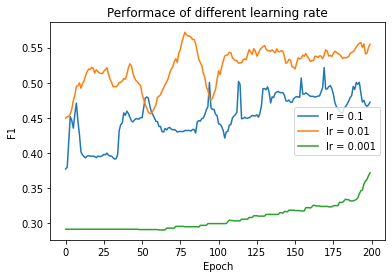

In [ ]:
# Please comment your code
#train data set preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)

#test data preprocession
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
for sentense in testing_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  lower_tokens = [t.lower() for t in tokenized_sentence]
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  test_tokensized_docs.append(lemmatizes)

model_train_docs=[]
for sentence in test_tokensized_docs:
  model_train_docs.append(sentence)
for sentence in train_tokensized_docs:
  model_train_docs.append(sentence)

#cread word list 
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1

# word vector
# FastText(SG)
ft_sg_model = FastText(model_train_docs, size=100, window=3, min_count=5, workers=2, sg=1)
emb_wordvec_dim = ft_sg_model.vector_size #200
emb_wordvec_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model:
        emb_wordvec_table.append(ft_sg_model[word])
    else:
        emb_wordvec_table.append([0]*emb_wordvec_dim)
emb_wordvec_table = np.array(emb_wordvec_table)

# Pre trained model
# glove-twitter-200
word_emb_model = api.load("glove-twitter-200") 
emb_pretrain_dim = word_emb_model.vector_size #200
emb_pretrain_table = []
for i, word in enumerate(word_list):
    if word in word_emb_model:
        emb_pretrain_table.append(word_emb_model[word])
    else:
        emb_pretrain_table.append([0]*emb_pretrain_dim)
emb_pretrain_table = np.array(emb_pretrain_table)

#Input concatenate
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
emb_table = []
for i, word in enumerate(word_list):
    if word in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],ft_sg_model[word]),0))
    elif word in ft_sg_model and word not in word_emb_model:
        emb_table.append(np.concatenate(([0]*emb_pretrain_dim,ft_sg_model[word]),0))
    elif word not in ft_sg_model and word in word_emb_model:
        emb_table.append(np.concatenate((word_emb_model[word],[0]*emb_wordvec_dim),0))    
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)


# Padding and encoding
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded
sent_encoded = encode_and_add_padding(train_tokensized_docs, seq_length, word_index)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)
unique_labels = np.unique(training_labels)

from sklearn.preprocessing import LabelEncoder
lEnc = LabelEncoder()
lEnc.fit(testing_labels)
test_label_encoded= lEnc.transform(testing_labels)

# Build model 1
# lr = 0.1, epoch = 400
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 200
learning_rate = 0.1
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trian_acc_lr1 =[]
train_f1_lr1 = []
test_acc_lr1 = []
test_f1_lr1 = []
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())
    trian_acc_lr1.append(acc)
    train_f1_lr1.append(f1_score(targets, predicted.cpu().numpy(),average='weighted'))

     ## Prediction(testset)
    test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
    test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
    test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device)     
    model.eval()
    outputs = model(test_input_torch)
    predicted = torch.argmax(outputs, 1)
    acc= accuracy_score(predicted.cpu().numpy(),test_targe_torch)
    test_acc_lr1.append(acc)
    test_f1_lr1.append(f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted'))


# Build model 2
# lr = 0.01, epoch = 400
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 200
learning_rate = 0.01
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size
# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trian_acc_lr2 =[]
train_f1_lr2 = []
test_acc_lr2 = []
test_f1_lr2 = []
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())
    trian_acc_lr2.append(acc)
    train_f1_lr2.append(f1_score(targets, predicted.cpu().numpy(),average='weighted'))


    test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
    test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
    test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 

    ## Prediction (testset)
    model.eval()
    outputs = model(test_input_torch)
    predicted = torch.argmax(outputs, 1)
    acc= accuracy_score(predicted.cpu().numpy(),test_targe_torch)
    test_acc_lr2.append(acc)
    test_f1_lr2.append(f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted'))


# Build model 3
# lr = 0.001, epoch = 400
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_sentences_encoded_pad = torch.from_numpy(np.array(sent_encoded)).to(device)
train_tags_y_pad = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)
from torch.utils.data import TensorDataset
train_data = TensorDataset(train_sentences_encoded_pad,train_tags_y_pad)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
vocab_size = len(word_list)
total_epoch = 200
learning_rate = 0.001
n_hidden =1
n_class = len(unique_labels)
emb_dim = word_emb_model.vector_size + ft_sg_model.vector_size

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

# Move the model to GPU
model = Bi_LSTM_Emb().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trian_acc_lr3 =[]
train_f1_lr3 = []
test_acc_lr3 = []
test_f1_lr3 = []
for epoch in range(total_epoch):  
    
    # Set the flag to training
    model.train()
    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = model(sentence) 
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    predicted = torch.argmax(outputs, -1)
    acc= accuracy_score(predicted.cpu().numpy(),targets.cpu().numpy())
    trian_acc_lr3.append(acc)
    train_f1_lr3.append(f1_score(targets, predicted.cpu().numpy(),average='weighted'))

    ## Prediction (testset)
    test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
    test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) 
    test_targe_torch = torch.from_numpy(np.array(test_label_encoded)).view(-1).to(device) 
    model.eval()
    outputs = model(test_input_torch)
    predicted = torch.argmax(outputs, 1)
    acc= accuracy_score(predicted.cpu().numpy(),test_targe_torch)
    test_acc_lr3.append(acc)
    test_f1_lr3.append(f1_score(test_targe_torch, predicted.cpu().numpy(),average='weighted'))


# plot F1 score
# epoch =200
plt.plot(range(200),test_f1_lr1,label='lr = 0.1')
plt.plot(range(200),test_f1_lr2,label='lr = 0.01')
plt.plot(range(200),test_f1_lr3,label='lr = 0.001')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('Performace of different learning rate')
plt.show()


# 5 - Test model via Colab Form Fields User Interface

In [5]:
#@title Personality Type Prediction

text = "I am thinking logically" #@param {type:"string"}


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '18GnqBFrXvXEKfuF1ITlczfa53bDSiXHa'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('best_classification_model.pt')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim.downloader as api
from sklearn.metrics import accuracy_score
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk.stem.porter import *
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from gensim.models import FastText
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)
import matplotlib.pyplot as plt
import pandas as pd
import re
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z



id = '16g474hdNsaNx0_SnoKuqj2BuwSEGdnbt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.csv')
import pandas as pd
training_data = pd.read_csv("/content/training_data.csv")
# Get the list of training data (posts)
training_posts=training_data['posts'].tolist()
# Get the list of corresponding labels for the training data (posts)
training_labels=training_data['type'].tolist()
# Process training data
pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
train_tokensized_docs = []
for sentense in training_posts:
  sentense_reurl = re.sub(pattern, '', sentense)
  clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
  tokenized_sentence = word_tokenize(clean_sentence)
  # lower 
  lower_tokens = [t.lower() for t in tokenized_sentence]
  #remove stop words
  sww = sw.words()
  tokenized_doc = [w for w in lower_tokens if not w in sww]
  # Stemming
  singles = [stemmer.stem(plural) for plural in tokenized_doc]
  # Lemmatisation
  lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
  train_tokensized_docs.append(lemmatizes)
# word list  
word_set = set() 
for sent in train_tokensized_docs:
    for word in sent:
        word_set.add(word)
word_set.add('[PAD]')
word_set.add('[UNKNOWN]')
word_list = list(word_set) 
word_list.sort()
word_index = {}
ind = 0
for word in word_list:
    word_index[word] = ind
    ind += 1
  
the_saved_model = torch.load('/content/best_classification_model.pt')
the_saved_model.eval()


pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
test_tokensized_docs = []
sentense_reurl = re.sub(pattern, '', text)
clean_sentence = re.sub(r'[^a-zA-Z\s]','',sentense_reurl)
tokenized_sentence = word_tokenize(clean_sentence)
lower_tokens = [t.lower() for t in tokenized_sentence]
tokenized_doc = [w for w in lower_tokens if not w in sww]
singles = [stemmer.stem(plural) for plural in tokenized_doc]
lemmatizes = [lemmatizer.lemmatize(word) for word in singles]
test_tokensized_docs.append(lemmatizes)
seq_length = 700
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent] # if word in sentence, word_index[word]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        if len(temp_encoded) > seq_length:
            temp_encoded=temp_encoded[:seq_length]
        sent_encoded.append(temp_encoded)
    return sent_encoded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_sent_encoded = encode_and_add_padding(test_tokensized_docs, seq_length, word_index)
test_input_torch = torch.from_numpy(np.array(test_sent_encoded)).to(device) #sent_encode: [[4, 6, 9, 0, 0], [4, 7, 5, 0, 0], [4, 3, 9, 0, 0], [4, 2, 8, 6, 5]]
outputs = the_saved_model(test_input_torch)
predicted = torch.argmax(outputs, 1)
if predicted == 0:
  print('positive')
else:
  print('negative')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


negative
